# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
from scipy.stats import shapiro
import pandas as pd
import numpy as np
from IPython.display import display

from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_recall_curve,roc_curve
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error, accuracy_score

#Grapthics
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Загрузка и подготовка данных

In [2]:
try:
    data_geo_0 =  pd.read_csv('/datasets/geo_data_0.csv')
except:
    data_geo_0 =  pd.read_csv('C:/datasets/geo_data_0.csvv')

try:
    data_geo_1 =  pd.read_csv('/datasets/geo_data_1.csv')
except:
    data_geo_1 =  pd.read_csv('C:/datasets/geo_data_1.csv')
    
try:
    data_geo_2 =  pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_geo_2 =  pd.read_csv('C:/datasets/geo_data_2.csv')

In [3]:
data_list = [data_geo_0,data_geo_1,data_geo_2]
for data in data_list:
    display(data.head())
    print(data.info()) 

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Загрузили данные, проверили корректность, приступаем к предобработке
</div>

In [4]:
for data in data_list:
    print(data.duplicated().sum())  

0
0
0


In [5]:
for data in data_list:
    print(data['id'].duplicated().value_counts())  
    duplicates = data[data['id'].duplicated()].id.tolist()
    display(data[data['id'].isin(duplicates)].sort_values(by = 'id'))

False    99990
True        10
Name: id, dtype: int64


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


False    99996
True         4
Name: id, dtype: int64


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


False    99996
True         4
Name: id, dtype: int64


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


In [6]:
for data in data_list:
    data.drop_duplicates(subset=['id'],inplace=True)
    print(data['id'].duplicated().sum())
    data.drop(columns=['id'],axis=1, inplace=True)
    display(data.head())

0


,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


0


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


0


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
пропущенные значения отсутствуют, явных дубликатов так же нет, неявные дубликаты наблюдались, так как причины непонятные, то удалили их, так же удалили столбец id, так как для дальнейшего анализа она нам не нужен, можно переходить к иследователькому анализу данных
</div>

In [7]:
def draw_grafic(columns,data):
    for i in columns:
        data[i].hist(bins=50, figsize=(10, 5), grid=True);
        plt.xlabel(i)
        plt.ylabel('Частота')
        plt.title(i)
        plt.show()
        data[i].plot(kind='box')
        plt.ylabel(i)
        plt.title(i)
        plt.show()
        stat, p_val = shapiro(data[i])
        if p_val < 0.5: print(i +' не нормальное')
        else: print(i +' нормальное')

In [8]:
data_geo_0.describe(include = 'all').style.background_gradient('coolwarm')

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500454,0.250141,2.502629,92.499684
std,0.871844,0.504430,3.248149,44.288304
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072572,-0.200877,0.287784,56.497069
50%,0.502405,0.250252,2.515969,91.847928
75%,1.073626,0.700640,4.715035,128.563699
max,2.362331,1.343769,16.003790,185.364347


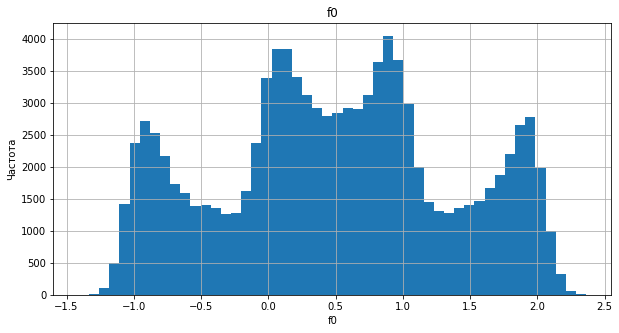

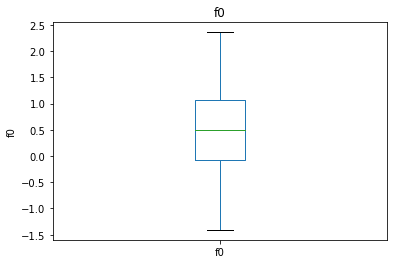

f0 не нормальное


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


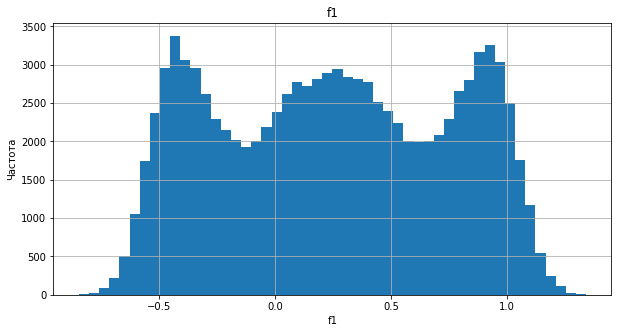

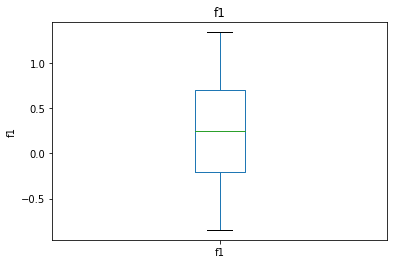

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


f1 не нормальное


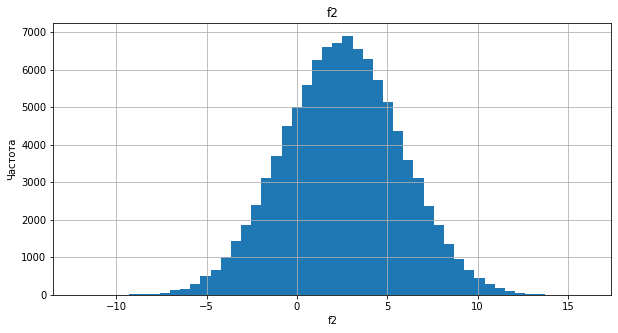

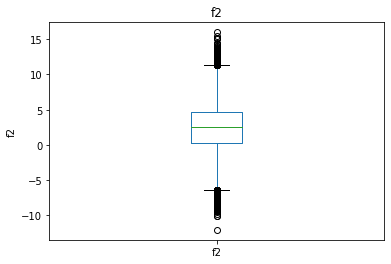

f2 не нормальное


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


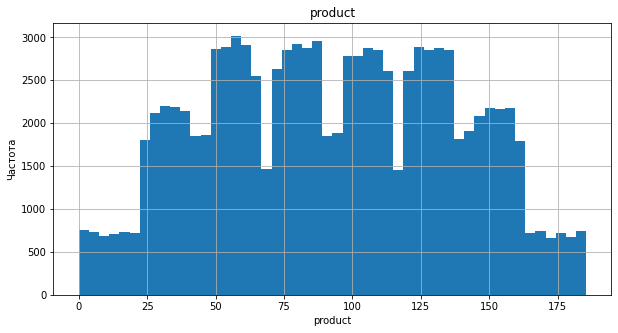

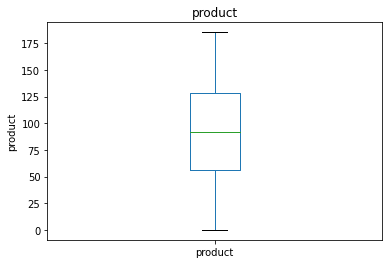

product не нормальное


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [9]:
col = ['f0','f1','f2','product']
draw_grafic(col, data_geo_0)

In [10]:
data_geo_1.describe(include = 'all').style.background_gradient('coolwarm')

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,1.141209,-4.796608,2.494501,68.823916
std,8.965815,5.119906,1.703579,45.944663
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011475,57.085625
75%,8.620964,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


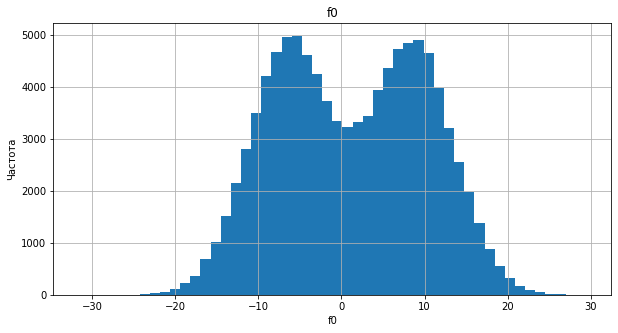

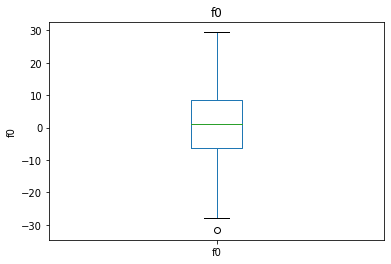

f0 не нормальное


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


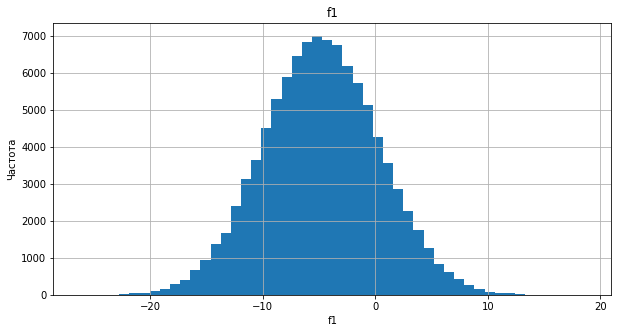

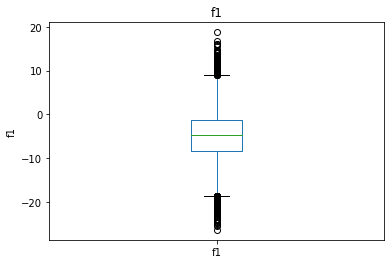

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


f1 не нормальное


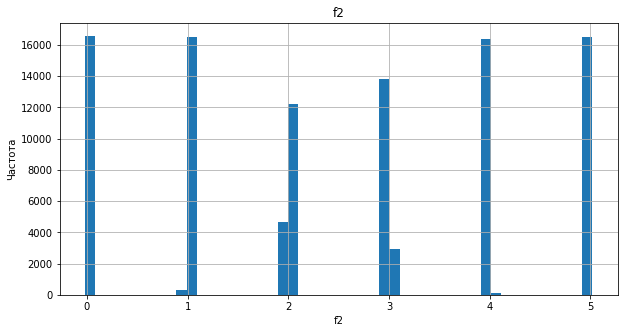

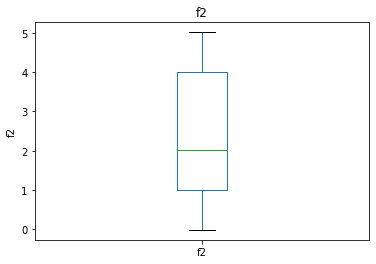

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


f2 не нормальное


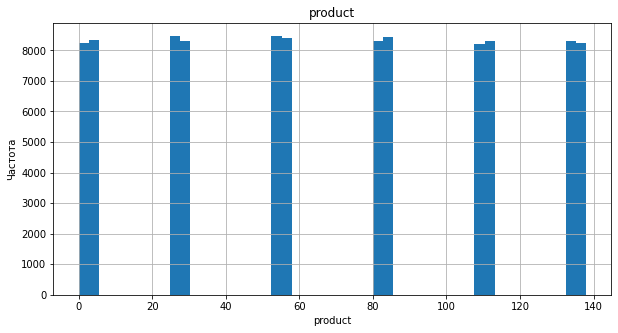

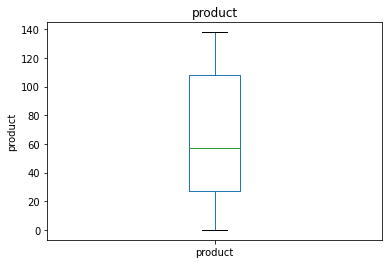

product не нормальное


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [11]:
col = ['f0','f1','f2','product']
draw_grafic(col, data_geo_1)

In [12]:
data_geo_2.describe(include = 'all').style.background_gradient('coolwarm')

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,0.002002,-0.002159,2.495084,94.998342
std,1.732052,1.730397,3.473482,44.749573
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174841,0.130269,59.450028
50%,0.009424,-0.009661,2.484236,94.925026
75%,1.158477,1.163523,4.858720,130.586815
max,7.238262,7.844801,16.739402,190.029838


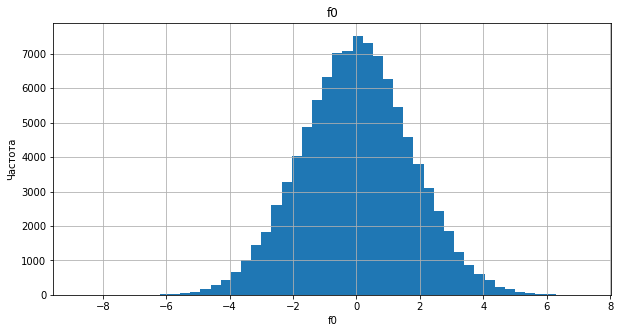

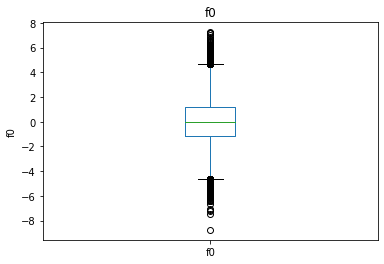

f0 нормальное


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


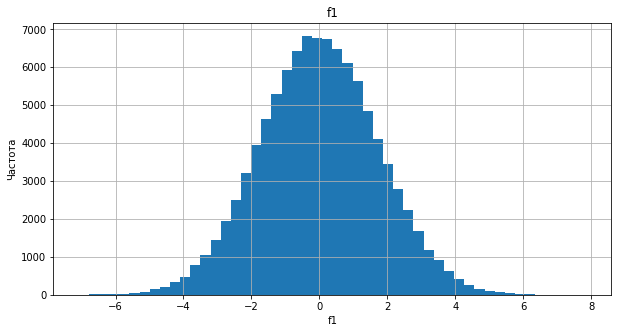

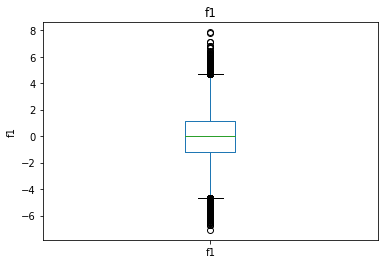

f1 нормальное


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


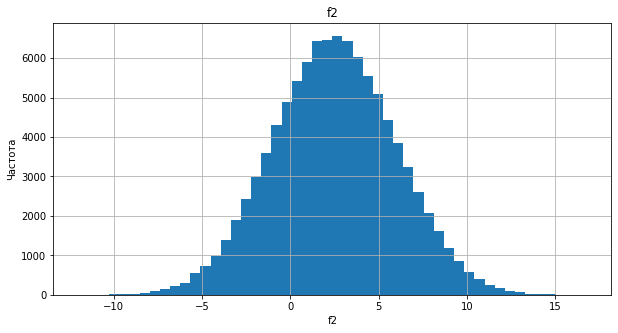

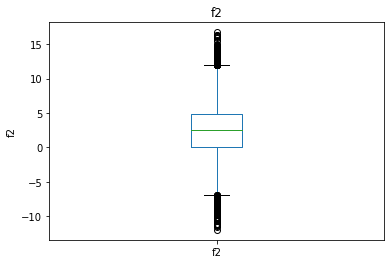

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


f2 не нормальное


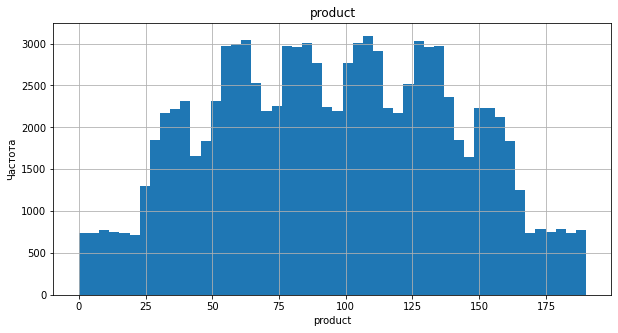

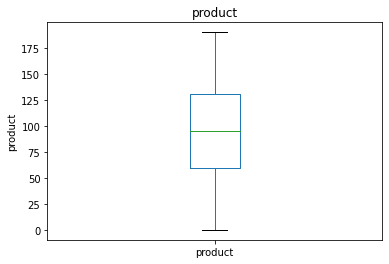

product не нормальное


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [13]:
col = ['f0','f1','f2','product']
draw_grafic(col, data_geo_2)

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
выбросы отсутствуют, данные имеют ненормальное распределение

In [14]:
data_geo_0.corr(method="spearman").style.background_gradient('coolwarm')

,f0,f1,f2,product
f0,1.000000,-0.471379,-0.002739,0.128379
f1,-0.471379,1.000000,0.001440,-0.181136
f2,-0.002739,0.001440,1.000000,0.486370
product,0.128379,-0.181136,0.486370,1.000000


In [15]:
data_geo_1.corr(method="spearman").style.background_gradient('coolwarm')

,f0,f1,f2,product
f0,1.000000,0.182247,-0.002024,-0.122901
f1,0.182247,1.000000,-0.003674,-0.033906
f2,-0.002024,-0.003674,1.000000,0.975604
product,-0.122901,-0.033906,0.975604,1.000000


In [16]:
data_geo_2.corr(method="spearman").style.background_gradient('coolwarm')

,f0,f1,f2,product
f0,1.000000,0.002471,0.000046,-0.002453
f1,0.002471,1.000000,0.000349,-0.001508
f2,0.000046,0.000349,1.000000,0.448459
product,-0.002453,-0.001508,0.448459,1.000000


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
корреляция отсутствует переходим к обучению модели
</div>

In [17]:
def split_data(data):
    features = data.drop(['product'],axis=1) 
    target = data['product']

    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=890)
    
    for df in features_train, features_valid, target_train, target_valid:
        df.reset_index(drop=True,inplace =True)
    print(features_train.shape, features_valid.shape, target_train.shape, target_valid.shape)
    return features_train, features_valid, target_train, target_valid

features_train_0, features_valid_0, target_train_0, target_valid_0 = split_data(data_geo_0)
features_train_1, features_valid_1, target_train_1, target_valid_1 = split_data(data_geo_1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = split_data(data_geo_2)

(74992, 3) (24998, 3) (74992,) (24998,)
(74997, 3) (24999, 3) (74997,) (24999,)
(74997, 3) (24999, 3) (74997,) (24999,)


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Разбили данные на обучающую и валидационную выборки в соотношении 75:25.
</div>

## Обучение и проверка модели

In [18]:

def metrics_calculate(features_train,features_valid,target_train,target_valid,predicted_valid,model):
    model_metrics = []
    
    _r2_score = r2_score(target_valid,predicted_valid)
    mse = mean_squared_error(target_valid, predicted_valid)
    rmse = mse**0.5
    mae = mean_absolute_error(target_valid, predicted_valid) 
    model_metrics.append([_r2_score,rmse,mae])
    return np.hstack((model_metrics))


def list_metrics():
    metrics = ['_r2_score','rmse','mae']
    return metrics

In [19]:
def model_LinearRegression(features_train,features_valid,target_train,target_valid):
    model = LinearRegression(n_jobs=120)
    model.fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)


    model_metrics = metrics_calculate(
        features_train,features_valid,target_train,target_valid,predicted_valid,model
    )
    return predicted_valid, model_metrics


model_metrics = []
predicted_valid_0,metrics =  model_LinearRegression(features_train_0, features_valid_0, target_train_0, target_valid_0)
model_metrics.append(np.hstack(([metrics,predicted_valid_0.mean()])))

predicted_valid_1,metrics =  model_LinearRegression(features_train_1, features_valid_1, target_train_1, target_valid_1)
model_metrics.append(np.hstack(([metrics,predicted_valid_1.mean()])))

predicted_valid_2,metrics =  model_LinearRegression(features_train_2, features_valid_2, target_train_2, target_valid_2)
model_metrics.append(np.hstack(([metrics,predicted_valid_2.mean()])))

model_metrics = pd.DataFrame(model_metrics,columns =['r2_score','rmse','mae','predicted_mean']
,index= ['region_0','region_1','region_2'])
display(model_metrics.T)

,region_0,region_1,region_2
r2_score,0.276148,0.999624,0.201078
rmse,37.642651,0.889656,39.949733
mae,31.011853,0.717067,32.735826
predicted_mean,92.482326,69.028199,95.021401


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Провели обучение модели, по результатам можно сказать, что показатели 	region_1 слишком хорошие, похоже имеется какие-то неполадки с данными, предсказания для 0 и 2 региона неплохие, ошибка в предсказание составляет все лишь 31.011853 и 32.735826 соответственно 
</div>

# Подготовка к расчету прибыли

In [20]:
budget = pow(10,10) 
revenue_one_thousand_barrel = 450*pow(10,3)
quantity_oil_well = 25000 

brakeven = budget/quantity_oil_well/200
print('Cумма, при которой скважина безубыточная равна {:.0f} тысяч рублей'.format(brakeven/pow(10,3))) 

#minimum_quantity_material= (budget/ revenue_one_thousand_barrel)/pow(10,3)
minimum_quantity_material= (budget/revenue_one_thousand_barrel)/200
print('Минимальный объем сырья для безубыточной разработки новой скважины составляет {:.1f} тысяч баррелей'
      .format(minimum_quantity_material))


data_geo_0['product'].describe()

Cумма, при которой скважина безубыточная равна 2 тысяч рублей
Минимальный объем сырья для безубыточной разработки новой скважины составляет 111.1 тысяч баррелей


count    99990.000000
mean        92.499684
std         44.288304
min          0.000000
25%         56.497069
50%         91.847928
75%        128.563699
max        185.364347
Name: product, dtype: float64

In [21]:
data_geo_1['product'].describe()


count    99996.000000
mean        68.823916
std         45.944663
min          0.000000
25%         26.953261
50%         57.085625
75%        107.813044
max        137.945408
Name: product, dtype: float64

In [22]:
data_geo_2['product'].describe()

count    99996.000000
mean        94.998342
std         44.749573
min          0.000000
25%         59.450028
50%         94.925026
75%        130.586815
max        190.029838
Name: product, dtype: float64

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Исправления: добавили разделение на 200 и умножение на 1000, чтобы найти показатели одной скважины в тысячах.
При сравнение со средним запасом продукта по регионам, увы никакой регион не удовлетволяет нашим значениям в 111 тысяч
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Нашли минимальную прибыль и минимальный объем сырья для скважи, сравнили их с показателями регионов, данные выглядят многообещающе, проверим прибыль для них
</div>

In [23]:
def revenue(target_valid,predicted_valid):
    predicted_valid_200_index = predicted_valid.sort_values(ascending=False)[:200].index
    target_valid_200 = target_valid[target_valid.index.isin(predicted_valid_200_index)]
    target_valid_200_sum = target_valid_200.sum().round(2)
    income = target_valid_200_sum *revenue_one_thousand_barrel
    profit =  income -budget
    return profit 

profit_0 = revenue(target_valid_0,pd.Series(predicted_valid_0))
profit_1 =revenue(target_valid_1,pd.Series(predicted_valid_1))
profit_2 =revenue(target_valid_2,pd.Series(predicted_valid_2))

# выведем данные
print('Валоваая прибыль для нулевого региона составила {:.2f} миллиарда:'.format(profit_0/pow(10,9)))
print('Валоваая прибыль для первого региона составила {:.2f} миллиарда:'.format(profit_1/pow(10,9)))
print('Валоваая прибыль для второго региона составила {:.2f} миллиарда:'.format(profit_2/pow(10,9)))

Валоваая прибыль для нулевого региона составила 3.12 миллиарда:
Валоваая прибыль для первого региона составила 2.42 миллиарда:
Валоваая прибыль для второго региона составила 2.51 миллиарда:


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Хоть третий регион и казался очень многообещающем, по факту наилучшим по показателем валовой прибыли у 200 лучших скважин нулевой регион его опередил, но так же все 3 показателя являются многообещающими
</div>

## Расчёт прибыли и рисков 

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
перейдем к использованию bootstap и методу квантелей, так как данные имеют ненормальное распределение
</div>

In [24]:
def bootstrap(target, probabilities):
    state = np.random.RandomState(890)

    values = []
    for i in range(1000):
        target_subsample = target.sample(n=500,replace=True,random_state=state)
        probs_subsample = probabilities[target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample))

    values = pd.Series(values)

    lower = values.quantile(0.025)/pow(10,9) 
    upper = values.quantile(0.975)/pow(10,9)
    mean = values.mean()/pow(10,9)

    risk = stats.percentileofscore(values,minimum_quantity_material)
    print("Средняя валовая прибыль {:.2f} миллиарда".format(mean))
    print("Границы 95% доверитлеьного интервала по валовой прибыли ({:.2f},{:.2f}) млрд.:".format( lower,upper))
    print("Риск убытков равен {:.1f}%".format(risk))
bootstrap_0 = bootstrap(target_valid_0,pd.Series(predicted_valid_0,index =target_valid_0.index ))
bootstrap_1 = bootstrap(target_valid_1,pd.Series(predicted_valid_1,index =target_valid_1.index))
bootstrap_2 = bootstrap(target_valid_2,pd.Series(predicted_valid_2,index =target_valid_2.index))

Средняя валовая прибыль 0.45 миллиарда
Границы 95% доверитлеьного интервала по валовой прибыли (-0.02,0.94) млрд.:
Риск убытков равен 3.6%
Средняя валовая прибыль 0.47 миллиарда
Границы 95% доверитлеьного интервала по валовой прибыли (0.08,0.87) млрд.:
Риск убытков равен 1.2%
Средняя валовая прибыль 0.33 миллиарда
Границы 95% доверитлеьного интервала по валовой прибыли (-0.23,0.84) млрд.:
Риск убытков равен 11.0%


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
после оценки рисков только 1 регион подходит под критерий риск менее 2.5% - это первый регион с показателем риска 1.2%, так же его границы имеют самый маленький разброс и он сам имеет самую большую прибыль, но данный анализ был проведен только по 200 лучшим скваженым, так как именно это требовалось по заданию
</div>